# Leads Predictor

O desafio prático do curso nos pede para gerarmos leads de mercado para 3 diferentes portfólios.

Por: **Pieter Voloshyn**

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import category_encoders as ce

import os
import gc

Vamos configurar nosso setup de visualização.

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

pd.set_option('display.max_rows', 200)

## Carregando databases

Vamos carregar a base do mercado e dos 3 portfólios para analisarmos em conjunto.

In [3]:
market_path = '../data/estaticos_market.csv.zip'
market = pd.read_csv(market_path, index_col=0, parse_dates=['dt_situacao'])
market.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
portfolio1_path = '../data/estaticos_portfolio1.csv'
pf1 = pd.read_csv(portfolio1_path, usecols=['id']).merge(market, on='id', how='inner')
pf1.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...,False,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,6.586301,5 a 10,False,...,NaN,NaN,NaN,0.0,0.0,2.0,NaN,-100.0,0.0,4
2,a95d6f30bba445bd3d6b0c5b36f865b38ec01d17336090...,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,8.010959,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,COMERCIO VAREJISTA,COMERCIO,20.863014,> 20,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc25...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,COMERCIO VAREJISTA,COMERCIO,18.726027,15 a 20,False,...,39.454762,91.2,19.333333,14.0,15.0,25.0,-6.666667,-44.0,0.0,3


In [5]:
portfolio2_path = '../data/estaticos_portfolio2.csv'
pf2 = pd.read_csv(portfolio2_path, usecols=['id']).merge(market, on='id', how='inner')
pf2.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,09e95c1a84049001d086470a8f320a19b076f955a89122...,True,AUTARQUIA ESTADUAL OU DO DISTRITO FEDERAL,AC,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,11.243836,10 a 15,False,...,99.961009,357.066667,25.533333,1361.0,1361.0,1383.0,0.000000,-1.590745,0.000000,0
1,dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728...,True,MUNICIPIO,RN,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,43.789041,> 20,False,...,149.173091,526.133333,23.200000,991.0,991.0,1306.0,0.000000,-24.119449,0.000000,0
2,16843c9ffb920170477118933798510d8d5f00f5c56c12...,True,SOCIEDADE SIMPLES LIMITADA,PI,ENTIDADES EMPRESARIAIS,SERVICOS DE EDUCACAO,SERVIÇO,16.389041,15 a 20,False,...,65.942017,149.033333,4.866667,119.0,104.0,113.0,14.423077,5.309735,6.250000,0
3,ff045934d90aab184dd15e66daf3b3c97193bda5449298...,True,MUNICIPIO,AM,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,39.671233,> 20,False,...,144.013013,555.766667,28.300000,1829.0,1829.0,1875.0,0.000000,-2.453333,0.000000,1
4,a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf0...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,PRODUTOS DE AGROPECUARIA,AGROPECUARIA,20.268493,> 20,False,...,14.610734,134.833333,2.933333,177.0,130.0,120.0,36.153846,47.500000,41.042345,0


In [6]:
portfolio3_path = '../data/estaticos_portfolio3.csv'
pf3 = pd.read_csv(portfolio3_path, usecols=['id']).merge(market, on='id', how='inner')
pf3.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...,True,MUNICIPIO,MA,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.813699,> 20,False,...,144.663535,259.166667,40.500000,745.0,745.0,745.0,0.000000,0.000000,0.00,2
1,16843c9ffb920170477118933798510d8d5f00f5c56c12...,True,SOCIEDADE SIMPLES LIMITADA,PI,ENTIDADES EMPRESARIAIS,SERVICOS DE EDUCACAO,SERVIÇO,16.389041,15 a 20,False,...,65.942017,149.033333,4.866667,119.0,104.0,113.0,14.423077,5.309735,6.25,0
2,1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185...,True,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,AM,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,40.380822,> 20,False,...,284.854706,557.866667,24.200000,170.0,170.0,177.0,0.000000,-3.954802,0.00,0
3,3aafa3a1f12f483740a52956af100223333d0e3c79bf2c...,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,43.854795,> 20,False,...,189.020309,506.966667,31.333333,151.0,151.0,151.0,0.000000,0.000000,0.00,0
4,c60431fbca90067f105570e1e8a684bcd7048205bbf6c4...,True,MUNICIPIO,RN,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,43.865753,> 20,False,...,238.418341,556.833333,34.033333,229.0,229.0,418.0,0.000000,-45.215311,0.00,1


Vamos ver o tamanho da encrenca.

In [7]:
print(market.shape)
print(pf1.shape)
print(pf2.shape)
print(pf3.shape)

(462298, 181)
(555, 181)
(566, 181)
(265, 181)


Beleza! Temos uma base bem grande e portfólios contendo algumas das empresas contidas na base de mercado.

## Limpando a base

Vamos olhar os tipos de dados, bem como a distribuição de dados nulos em todas as bases em conjunto.

In [8]:
def basic_summary(market, pf1, pf2, pf3):
    return pd.DataFrame({
        'market dtype': market.dtypes,
        'market nulls': market.isna().sum(),
        'market nulls (%)': market.isna().mean() * 100,
        'portfolio 1 nulls': pf1.isna().sum(),
        'portfolio 1 nulls (%)': pf1.isna().mean() * 100,
        'portfolio 2 nulls': pf2.isna().sum(),
        'portfolio 2 nulls (%)': pf2.isna().mean() * 100,
        'portfolio 3 nulls': pf3.isna().sum(),
        'portfolio 3 nulls (%)': pf3.isna().mean() * 100,
    })

dfs_info = basic_summary(market, pf1, pf2, pf3)
dfs_info

,market dtype,market nulls,market nulls (%),portfolio 1 nulls,portfolio 1 nulls (%),portfolio 2 nulls,portfolio 2 nulls (%),portfolio 3 nulls,portfolio 3 nulls (%)
id,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
fl_matriz,bool,0,0.000000,0,0.000000,0,0.000000,0,0.000000
de_natureza_juridica,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
sg_uf,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
natureza_juridica_macro,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
de_ramo,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
setor,object,1927,0.416831,0,0.000000,0,0.000000,0,0.000000
idade_empresa_anos,float64,0,0.000000,0,0.000000,0,0.000000,0,0.000000
idade_emp_cat,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
fl_me,bool,0,0.000000,0,0.000000,0,0.000000,0,0.000000


Note que temos algumas features que possuem dados nulos, mas em nenhum portfólio isso consta. Vou remover da base de mercado para evitarmos problemas.

In [9]:
filt = (dfs_info['market nulls']>0) & \
       (dfs_info['portfolio 1 nulls']==0) & \
       (dfs_info['portfolio 2 nulls']==0) & \
       (dfs_info['portfolio 3 nulls']==0)

total_rows = market.shape[0]
cols = list(market.columns[filt])
print(f'Removendo dados nulos das colunas: \n{cols}')

market.dropna(subset=cols, inplace=True)
print(f'.. {total_rows - market.shape[0]} linhas removidas')

Removendo dados nulos das colunas: 
['setor', 'dt_situacao', 'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo', 'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo', 'sg_uf_matriz', 'fl_simples_irregular', 'fl_passivel_iss']
.. 1945 linhas removidas


Agora, vamos remover todas as colunas que possuam mais de 10% de dados nulos. Vamos manter apenas dessa a feature `nm_micro_regiao`, pois vamos cruzar com uma outra base mais adiante.

In [10]:
filt = (dfs_info['market nulls (%)']>10)

total_cols = market.shape[1]
cols = list(market.columns[filt])
cols.remove('nm_micro_regiao')
print(f'Removendo colunas: \n{cols}')

market.drop(columns=cols, inplace=True)
pf1.drop(columns=cols, inplace=True)
pf2.drop(columns=cols, inplace=True)
pf3.drop(columns=cols, inplace=True)
print(f'.. {total_cols - market.shape[1]} colunas removidas')

Removendo colunas: 
['vl_total_tancagem', 'vl_total_veiculos_antt', 'vl_total_veiculos_leves', 'vl_total_veiculos_pesados', 'fl_optante_simples', 'qt_art', 'vl_total_tancagem_grupo', 'vl_total_veiculos_antt_grupo', 'vl_potenc_cons_oleo_gas', 'fl_optante_simei', 'de_indicador_telefone', 'vl_frota', 'empsetorcensitariofaixarendapopulacao', 'nm_meso_regiao', 'qt_socios', 'qt_socios_pf', 'qt_socios_pj', 'idade_media_socios', 'idade_maxima_socios', 'idade_minima_socios', 'qt_socios_st_regular', 'qt_socios_st_suspensa', 'qt_socios_masculino', 'qt_socios_feminino', 'qt_socios_pep', 'qt_alteracao_socio_total', 'qt_alteracao_socio_90d', 'qt_alteracao_socio_180d', 'qt_alteracao_socio_365d', 'qt_socios_pj_ativos', 'qt_socios_pj_nulos', 'qt_socios_pj_baixados', 'qt_socios_pj_suspensos', 'qt_socios_pj_inaptos', 'vl_idade_media_socios_pj', 'vl_idade_maxima_socios_pj', 'vl_idade_minima_socios_pj', 'qt_coligados', 'qt_socios_coligados', 'qt_coligados_matriz', 'qt_coligados_ativo', 'qt_coligados_baixad

Removemos um total de 142 colunas. Agora temos um universo bem menor para trabalharmos.

In [11]:
dfs_info = basic_summary(market, pf1, pf2, pf3)
dfs_info

,market dtype,market nulls,market nulls (%),portfolio 1 nulls,portfolio 1 nulls (%),portfolio 2 nulls,portfolio 2 nulls (%),portfolio 3 nulls,portfolio 3 nulls (%)
id,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
fl_matriz,bool,0,0.000000,0,0.000000,0,0.000000,0,0.000000
de_natureza_juridica,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
sg_uf,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
natureza_juridica_macro,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
de_ramo,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
setor,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
idade_empresa_anos,float64,0,0.000000,0,0.000000,0,0.000000,0,0.000000
idade_emp_cat,object,0,0.000000,0,0.000000,0,0.000000,0,0.000000
fl_me,bool,0,0.000000,0,0.000000,0,0.000000,0,0.000000


OK, agora vamos preencher nulos da seguinte forma:

* Features do tipo *flag* ou booleanas começam com `fl_`, então vamos preencher com `False` e converter para `int`.
* Features do tipo `float` possuem um padrão na nomenclatura. Para estes casos, vamos preencher com a média.
* Features do tipo `object` vamos registrar com `SEM INFORMACAO` para as que começam com `de_` e `OUTRA` para as outras.
* Features do tipo `datetime` vamos deixar do jeito que está.
* Todas as demais serão consideradas como do tipo `int` e para elas vamos usar `0`.

In [12]:
for col in market.columns:
    if 'fl_' in col:
        if {'SIM', 'NAO'} <= set(market[col]):
            market[col] = (market[col]=='SIM')
        market[col] = market[col].fillna(False).astype('int')
    elif 'vl_' in col or 'media_' in col or 'max_' in col or 'min_' in col or 'percent_' in col: 
        mean = market[col].mean()
        market[col] = market[col].fillna(mean)
    elif market[col].dtype=='object':
        market[col] = market[col].fillna('SEM INFORMACAO' if 'de_' in col else 'OUTRA')
    elif 'dt_' in col:
        pass
    else:
        market[col] = market[col].fillna(0).astype('int')

## Feature Engineering

Vamos começar com as features do tipo `object`. Vamos olhar quais dados temos nelas.

In [13]:
obj_cols = market.select_dtypes('object').columns[1:]

for col in obj_cols:
    print(col)
    print(market[col].unique())
    print()

de_natureza_juridica
['SOCIEDADE EMPRESARIA LIMITADA' 'EMPRESARIO INDIVIDUAL' 'COOPERATIVA'
 'ASSOCIACAO PRIVADA' 'ENTIDADE SINDICAL' 'CONSORCIO DE SOCIEDADES'
 'SOCIEDADE DE ECONOMIA MISTA' 'CONDOMINIO EDILICIO'
 'ORGAO PUBLICO DO PODER EXECUTIVO FEDERAL' 'MUNICIPIO'
 'ORGAO DE DIRECAO LOCAL DE PARTIDO POLITICO' 'SOCIEDADE ANONIMA ABERTA'
 'EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA'
 'CANDIDATO A CARGO POLITICO ELETIVO' 'EMPRESA INDIVIDUAL IMOBILIARIA'
 'ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU DO DISTRITO FEDERAL'
 'SOCIEDADE SIMPLES LIMITADA' 'FUNDACAO PRIVADA'
 'ORGAO PUBLICO DO PODER EXECUTIVO MUNICIPAL' 'SOCIEDADE ANONIMA FECHADA'
 'ORGANIZACAO RELIGIOSA' 'SOCIEDADE UNIPESSOAL DE ADVOCACIA'
 'SOCIEDADE SIMPLES PURA' 'AUTARQUIA FEDERAL'
 'ORGAO PUBLICO DO PODER JUDICIARIO ESTADUAL' 'EMPRESA PUBLICA'
 'SOCIEDADE EMPRESARIA EM NOME COLETIVO' 'AUTARQUIA MUNICIPAL'
 'FUNDO PUBLICO' 'AUTARQUIA ESTADUAL OU DO DISTRITO FEDERAL'
 'FUNDACAO PUBLICA DE DIREI

['VERDE' 'CINZA' 'AMARELO' 'LARANJA' 'SEM INFORMACAO' 'AZUL' 'VERMELHO']

de_saude_rescencia
['ACIMA DE 1 ANO' 'ATE 1 ANO' 'SEM INFORMACAO' 'ATE 3 MESES' 'ATE 6 MESES']

de_nivel_atividade
['ALTA' 'BAIXA' 'MEDIA' 'SEM INFORMACAO' 'MUITO BAIXA']

nm_micro_regiao
['NATAL' 'TERESINA' 'MANAUS' 'PAU DOS FERROS'
 'AGLOMERACAO URBANA DE SAO LUIS' 'PARINTINS' 'MOSSORO' 'UMARIZAL' 'OUTRA'
 'COARI' 'LITORAL SUL' 'BAIXO PARNAIBA PIAUIENSE' 'SAO RAIMUNDO NONATO'
 'AGRESTE POTIGUAR' 'MEDIO MEARIM' 'GURUPI' 'BRASILEIA' 'SERIDO OCIDENTAL'
 'ALTO MEDIO GURGUEIA' 'CHAPADAS DO EXTREMO SUL PIAUIENSE' 'CHAPADINHA'
 'PRESIDENTE DUTRA' 'ALTO MEARIM E GRAJAU' 'FLORIANO' 'CAXIAS'
 'IMPERATRIZ' 'CHAPADAS DO ALTO ITAPECURU' 'CAMPO MAIOR' 'CODO'
 'BAIXADA MARANHENSE' 'ITACOATIARA' 'RIO BRANCO' 'PINDARE' 'PIO IX'
 'SERIDO ORIENTAL' 'LENCOIS MARANHENSES' 'LITORAL NORDESTE' 'VALE DO ACU'
 'LITORAL PIAUIENSE' 'BORBOREMA POTIGUAR' 'CHAPADAS DAS MANGABEIRAS'
 'RIO PRETO DA EVA' 'COELHO NETO' 'BOCA DO ACRE' 'BERTOLINIA

Vamos remover a coluna `dt_situacao`.

In [14]:
cols_to_drop = ['dt_situacao']
market.drop(columns=cols_to_drop, inplace=True)

Vou remover a feature `sg_uf_matriz` por achar que possui alta cardinalidade e pode ser muito redundante em muitos casos se compararmos com a feature `sg_uf`.

In [15]:
cols_to_drop = ['sg_uf_matriz']
market.drop(columns=cols_to_drop, inplace=True)

Vou remover as features que julgo possuírem alta cardinalidade.

In [16]:
cols_to_drop = ['de_natureza_juridica', 'nm_divisao', 'nm_segmento']
market.drop(columns=cols_to_drop, inplace=True)

Vou remover features categóricas de features numéricas que temos na base. Vou usar as numéricas.

In [17]:
cols_to_drop = ['idade_emp_cat', 'de_saude_rescencia', 'de_faixa_faturamento_estimado', 'de_faixa_faturamento_estimado_grupo']
market.drop(columns=cols_to_drop, inplace=True)

Vou criar 2 features para indicar a saúde tributária, se boa ou ruim. Se estiver zerado nas duas é porque a situação está no meio.

In [18]:
market['fl_saude_tributaria_boa'] = (market['de_saude_tributaria']=='VERDE').astype('int')
market['fl_saude_tributaria_ruim'] = (market['de_saude_tributaria']=='VERMELHO').astype('int')
market.drop(columns=['de_saude_tributaria'], inplace=True)

Vou criar uma feature ordinal na mão para o nível de atividade.

In [19]:
de_nivel_atividade_mapper = {
    'SEM INFORMACAO': 0,
    'MUITO BAIXA': 1,
    'BAIXA': 2,
    'MEDIA': 3,
    'ALTA': 4
}

market['de_nivel_atividade_enc'] = market['de_nivel_atividade'].map(de_nivel_atividade_mapper, na_action='ignore').astype('int')
market.drop(columns=['de_nivel_atividade'], inplace=True)

Bem, aqui eu aproveitei uma base gerada neste [link](https://github.com/codenation-dev/squad-1-ad-data-science-1/blob/master/analysis/Save_IBGE_data_for_Map_Visualization_in_Recommendation_System.ipynb) para ter a latitude e longitude por microrregião. A ideia é, ao invés de criar uma feature para cada microrregião com `OneHotEncoder`, vou usar as posições GPS.

In [20]:
microregioes = pd.read_csv('../data/coord_geograficas_microrregioes_brasil.csv')
microregioes.head()

,nm_uf,nm_micro,lng,lat
0,SAO PAULO,ADAMANTINA,-50.997688,-21.706115
1,ESPÍRITO SANTO,AFONSO CLAUDIO,-41.018390,-20.191878
2,MARANHÃO,AGLOMERACAO URBANA DE SAO LUIS,-44.142982,-2.562962
3,SERGIPE,AGRESTE DE ITABAIANA,-37.411976,-10.729138
4,SERGIPE,AGRESTE DE LAGARTO,-37.680786,-10.921736


Só vamos confirmar se temos todas as microrregiões.

In [21]:
set(market['nm_micro_regiao']) - set(microregioes['nm_micro'])

{'OUTRA'}

Agora é só juntar tudo.

In [22]:
microregioes = microregioes.rename(columns={'nm_micro': 'nm_micro_regiao'})[['nm_micro_regiao', 'lng', 'lat']]

In [23]:
market = pd.merge(market, microregioes, on='nm_micro_regiao', how='left')
market.drop(columns=['nm_micro_regiao'], inplace=True)

In [24]:
market['lat'].fillna(market['lat'].mean(), inplace=True)
market['lng'].fillna(market['lng'].mean(), inplace=True)

## Criando pipeline

Vamos começar separando nossas features por tipo.

### Features categóricas

In [25]:
categorical_features = list(market.select_dtypes('object').columns[1:])
categorical_features

['sg_uf', 'natureza_juridica_macro', 'de_ramo', 'setor']

### Features ordinais

In [26]:
ordinal_features = [
    'de_nivel_atividade_enc',
]

ordinal_features

['de_nivel_atividade_enc']

### Features do tipo *flag*

In [27]:
flag_features = [col for col in market.columns if col.startswith('fl_')]
flag_features

['fl_matriz',
 'fl_me',
 'fl_sa',
 'fl_epp',
 'fl_mei',
 'fl_ltda',
 'fl_st_especial',
 'fl_email',
 'fl_telefone',
 'fl_rm',
 'fl_spa',
 'fl_antt',
 'fl_veiculo',
 'fl_simples_irregular',
 'fl_passivel_iss',
 'fl_saude_tributaria_boa',
 'fl_saude_tributaria_ruim']

### Features numéricas

In [28]:
numeric_features = list(market.columns[~market.columns.isin(['id'] + categorical_features + ordinal_features + flag_features)])
numeric_features

['idade_empresa_anos',
 'vl_total_veiculos_pesados_grupo',
 'vl_total_veiculos_leves_grupo',
 'nu_meses_rescencia',
 'vl_faturamento_estimado_aux',
 'vl_faturamento_estimado_grupo_aux',
 'qt_filiais',
 'lng',
 'lat']

### Correlação

Antes de mais nada, vamos dar só uma última olhada nas features de ordem numérica para saber se podemos tirar mais alguma feature. Ou por não ter relevância ou por indicar multi-colinearidade.

In [29]:
def plot_heatmap(dataframe):
    """
    Plota heatmap de correlação dos dados nulos.
    
    :param dataframe: pd.DataFrame com os dados para serem correlacionados.
    """
    fig, ax = plt.subplots(figsize=(20, 20))
    corr = dataframe.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, vmin=-1, vmax=1, fmt='.1f', ax=ax)

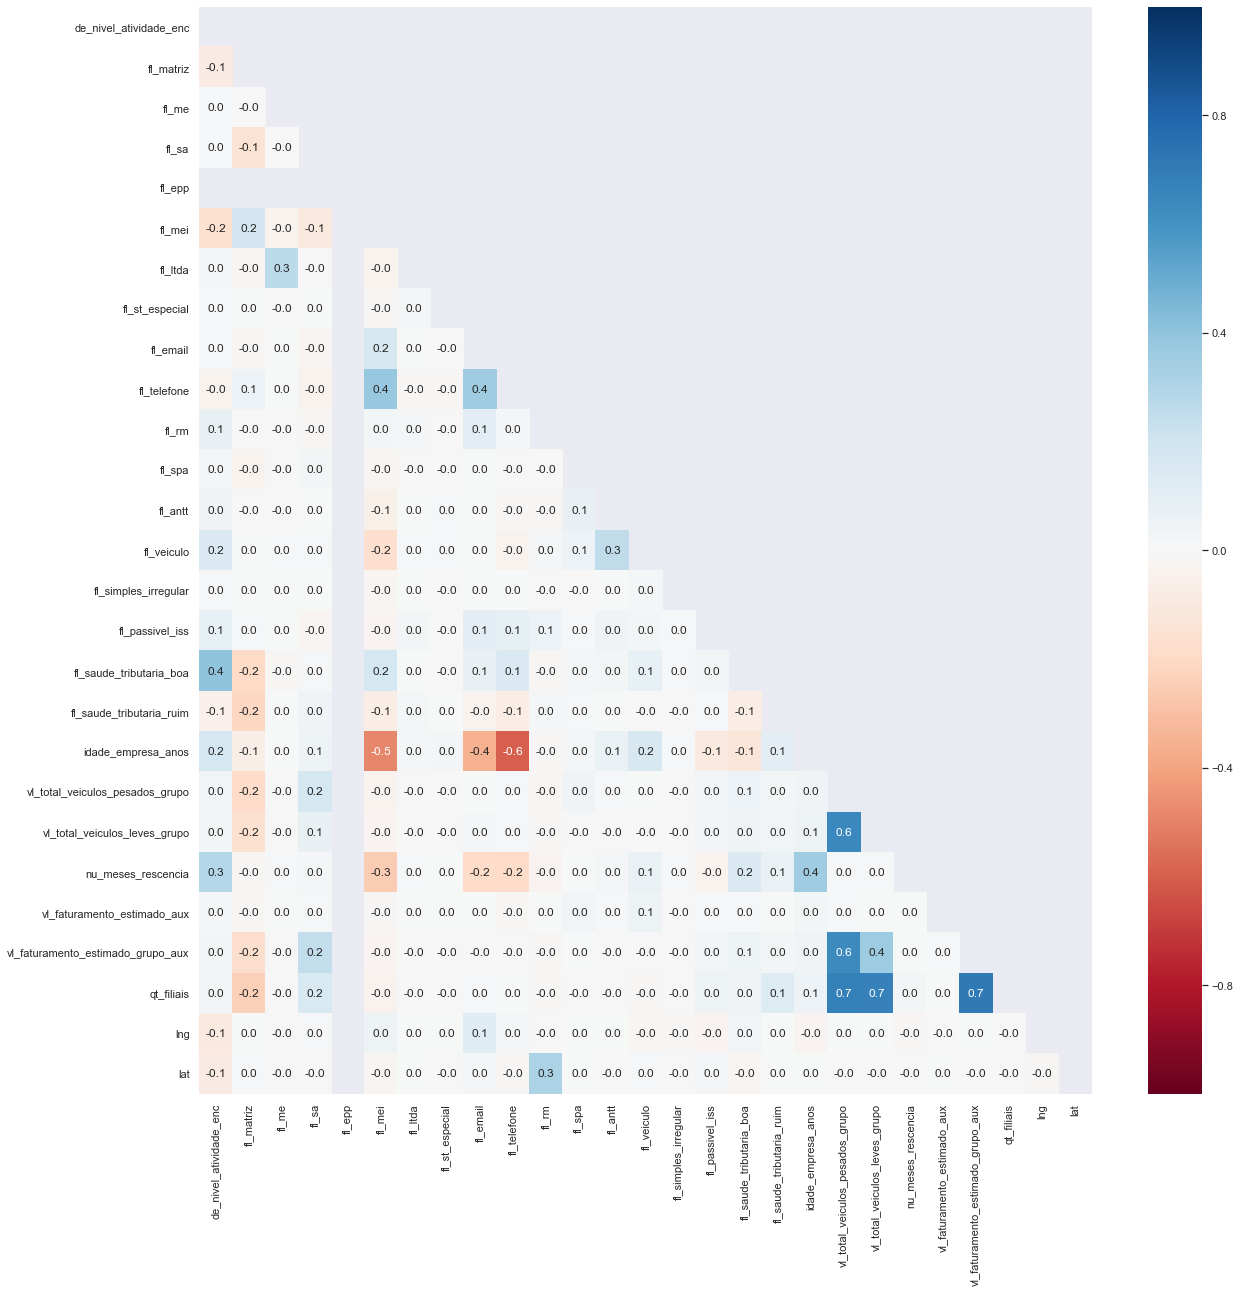

In [30]:
plot_heatmap(market[ordinal_features + flag_features + numeric_features])

Legal! Dá para *dropar* algumas features pela sua irrelevância.

In [31]:
cols_to_drop = [
    'fl_epp',
    'fl_ltda',
    'fl_st_especial',
    'fl_spa',
    'fl_simples_irregular'
]

market.drop(columns=cols_to_drop, inplace=True)

flag_features = [col for col in market.columns if col.startswith('fl_')]
flag_features

['fl_matriz',
 'fl_me',
 'fl_sa',
 'fl_mei',
 'fl_email',
 'fl_telefone',
 'fl_rm',
 'fl_antt',
 'fl_veiculo',
 'fl_passivel_iss',
 'fl_saude_tributaria_boa',
 'fl_saude_tributaria_ruim']

Vou remover as features de posição GPS, pois quero dar um tratamento diferente para elas, mesmo elas sendo numéricas.

In [32]:
numeric_features.remove('lat')
numeric_features.remove('lng')
numeric_features

['idade_empresa_anos',
 'vl_total_veiculos_pesados_grupo',
 'vl_total_veiculos_leves_grupo',
 'nu_meses_rescencia',
 'vl_faturamento_estimado_aux',
 'vl_faturamento_estimado_grupo_aux',
 'qt_filiais']

### Criação do pipeline de processamento

Eis que vos apresento nosso pipeline.

* Para as features numéricas, vamos aplicar um log para evitar valores muito altos e isso trazer uma distância muito grande.
* Para as categóricas, vamos usar `OneHotEncoder`.
* Para algumas features que quero aplicar um peso maior, vou usar `OneHotEncoder` seguido de um multiplicador.
* Para as features ordinais, vamos usar `HelmertEncoder` que trabalha bem com esse tipo de feature.
* Para as features de GPS, vamos padronizar.

No final de tudo vamos aplicar um `PCA`.

In [33]:
def mul(x, y):
    """
    Função lero-lero de multiplicação. É importante definir se quisermos deixar nosso pipeline pickeable.
    """
    return x*y

In [69]:
# como vou dar peso à feature de_ramo, vou redefinir as features categóricas
categorical_features = ['sg_uf', 'natureza_juridica_macro', 'setor']
# essas são as features que quero dar maior peso
weight_categorical_features = ['de_ramo', 'fl_matriz', 'fl_sa', 'fl_saude_tributaria_boa']

numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

weight_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('mul', FunctionTransformer(mul, kw_args={'y': 2}))
])

ordinal_transformer = Pipeline(steps=[
    ('he', ce.HelmertEncoder())
])

gps_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('wcat', weight_categorical_transformer, weight_categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('gps', gps_transformer, ['lat', 'lng'])
    ],
    remainder='passthrough'
)

preprocessor = Pipeline(steps=[
    ('col', column_transformer),
    ('pca', PCA(n_components=0.95))
])

# nosso X será a base de mercado sem a coluna id
X = preprocessor.fit_transform(market.drop(columns=['id']))

## Gerando leads

Antes de gerarmos nossos leads, vamos projetar os dados para avaliar onde se encontra o portfólio dentro da base de mercado.

Vamos tomar como base o portfólio 1.

In [70]:
pf1 = pd.merge(pf1[['id']], market, on='id', how='inner')
X_pf1 = preprocessor.transform(pf1.drop(columns=['id']))

### Projetando mercado e portfólio

Em cinza teremos as projeções do mercado e em verde, nosso portfólio.

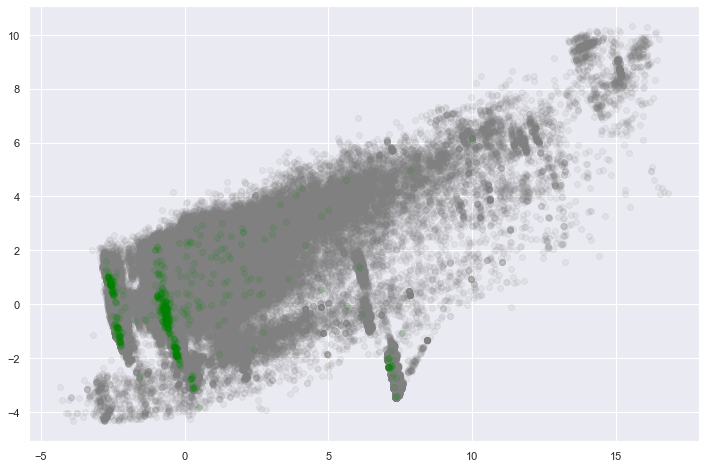

In [71]:
pca = PCA(n_components=2)

market_points = pca.fit_transform(X)
plt.scatter(market_points[:, 0], market_points[:, 1], c='gray', alpha=0.1)

pf1_points = pca.transform(X_pf1)
plt.scatter(pf1_points[:, 0], pf1_points[:, 1], c='green', alpha=0.1);

### Gerando leads com `NearestNeighbors`

A ideia aqui será pegarmos para cada item do portfólio seus vizinhos mais próximos. Iremos descontar aqueles que já estão no portfólio e faremos a contagem dos leads que foram apontados mais de uma vez.

In [102]:
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine').fit(X)

In [73]:
def generate_leads(portfolio, n_leads=100):
    """
    Gera leads para o portfólio indicado.
    
    :param portfolio: pd.DataFrame contendo os ID's do portfólio
    :param n_leads: indica quantos leads queremos retornar. Quando None, retorna todos que achar.
    :returns: ID's dos leads
    """
    # do portfolio só nos interessa a coluna id, que aí podemos fazer um inner join com nosso mercado
    df = pd.merge(portfolio[['id']], market, on='id', how='inner')
    # realizarmos o processamento de features
    X_pf = preprocessor.transform(df.drop(columns=['id']))
    
    # pegamos os índices dos vizinhos mais próximos para cada ponto do portfolio
    distances, indices = nn_model.kneighbors(X_pf)
    distances = distances.flatten()
    indices = indices.flatten()
    
    # vamos remover os itens que existem dentro do portfolio
    mask = ~np.isin(indices, set(portfolio['id']))
    distances = distances[mask]
    indices = indices[mask]
    
    # agora vamos contar os duplicados e ordenaremos pela contagem e pela média da distância
    data = set(zip(distances, indices))
    results = pd.DataFrame(data, columns=['distances', 'indices'])
    top_indices = results.groupby('indices')\
                         .agg(count=('indices', 'count'), 
                              distances=('distances', 'mean'))\
                         .sort_values(['count', 'distances'], ascending=[False, True])\
                         .index.values
    
    if n_leads is not None:
        top_indices = top_indices[:n_leads]
    
    return market.loc[top_indices, 'id']

Hora de testar. Vamos gerar 1000 leads para nosso portfólio 1.

In [74]:
leads = generate_leads(pf1, n_leads=1000)

In [75]:
leads.head()

44482     db4ac795ca84e1e7afec4f59cb98537b82b3b90c5a54d2...
85473     a73d1995bc13cc8362d09c4ae024669d4d7c6747b038d5...
263967    da4569705588bc5d2dda1526442629554225e71d16628b...
423209    e9bcd1d17db47ad4995e7fee19114b6a5b4a0d3ae3aca4...
445235    727db45f9ac0bec1a7f8c3d900790b9664cef1c445a937...
Name: id, dtype: object

Vamos projetar nossos leads por cima do nosso portfolio.

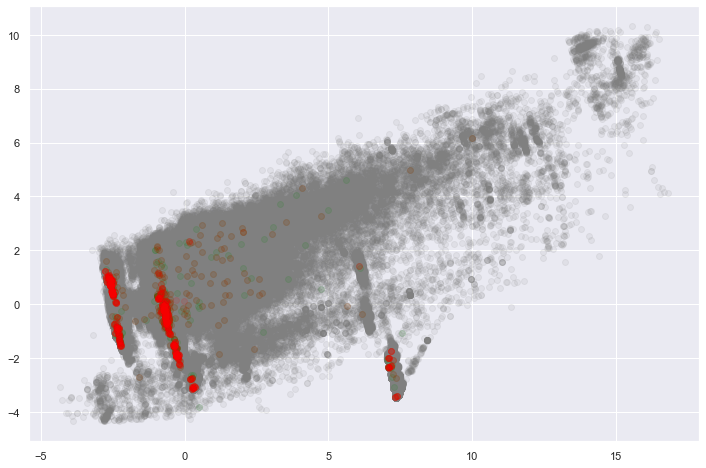

In [76]:
plt.scatter(market_points[:, 0], market_points[:, 1], c='gray', alpha=0.1)
plt.scatter(pf1_points[:, 0], pf1_points[:, 1], c='green', alpha=0.1)

predicted_points = pca.transform(X[market['id'].isin(leads)])
plt.scatter(predicted_points[:, 0], predicted_points[:, 1], c='red', alpha=0.1);

Olha que legal. As projeções dos leads batem muito próximo das projeções do portfolio. O que é bom.

## Testando nossos leads

Vamos agora fazer o seguinte. Vamos dividir nossos portfólios em duas partes. Treinar em uma parte e testar na outra. Teoricamente, devemos ver semelhança entre os leads e o que já faz parte do portfólio.

In [77]:
def calculate_accuracy(ids_true, ids_pred):
    """
    Função para calcular o percentual de leads que já fazem parte do nosso portfólio
    """
    return len(set(ids_true) & set(ids_pred)) / len(set(ids_true))

In [121]:
def calculate_mc_accuracy(market, portfolio, sample_size, n_trials, random_state=None):
    """
    Função para calcular a média de acertos no aleatório usando simulação de monte-carlo.
    
    :param market: DataFrame contendo os dados do mercado
    :param portfolio: DataFrame contendo os dados do portfolio
    :param sample_size: número de sugestões que iremos avaliar por vez
    :param n_trials: número de execuções
    :param random_state: quando diferente de None, indica a semente randômica
    :returns: acurácia média
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    market_ids = market['id']
    ids_true = set(portfolio['id'])
    accuracies = np.zeros(n_trials)
    for k in range(n_trials):
        random_suggestion = market_ids.sample(n=sample_size)
        accuracies[k] = calculate_accuracy(ids_true, random_suggestion)
    return np.mean(accuracies)

### Portfólio 1

In [78]:
pf1_train, pf1_valid = train_test_split(pf1[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf1_train.shape)
print(pf1_valid.shape)

In [103]:
preds = generate_leads(pf1_train, n_leads=None)

In [122]:
acc = calculate_accuracy(pf1_valid['id'], preds)
mc_acc = calculate_mc_accuracy(market, pf1_valid, len(preds), 1000, random_state=0)

print(f'O modelo indicou um total de {len(preds)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 1989 sugestões. Destes, 9.73% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.46%.


Em um primeiro momento, achei o resultado bem aquém daquilo que gostaria, 9.7% dos meus 30% do portfólio 1 já faziam parte de uma lista de 1989 sugestões, mas se pensarmos no tamanho da base e na quantidade de sugestões, o número até que fica interessante. Pode ser que o tipo de cliente que já esteja em sua carteira seja bem diversificado ou bastante comum. 

### Portfólio 2

In [124]:
pf2_train, pf2_valid = train_test_split(pf2[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf2_train.shape)
print(pf2_valid.shape)

(396, 1)
(170, 1)


In [125]:
preds = generate_leads(pf2_train, n_leads=None)

In [126]:
acc = calculate_accuracy(pf2_valid['id'], preds)
mc_acc = calculate_mc_accuracy(market, pf2_valid, len(preds), 1000, random_state=0)

print(f'O modelo indicou um total de {len(preds)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 1327 sugestões. Destes, 62.35% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.26%.


Opa! Que legal! Listamos pouco mais de 1300 sugestões sendo que 62.4% dos meus 30% do portfólio 2 já faziam parte.

### Portfólio 3

In [87]:
pf3_train, pf3_valid = train_test_split(pf3[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf3_train.shape)
print(pf3_valid.shape)

In [127]:
preds = generate_leads(pf3_train, n_leads=None)

In [128]:
acc = calculate_accuracy(pf3_valid['id'], preds)
mc_acc = calculate_mc_accuracy(market, pf3_valid, len(preds), 1000, random_state=0)

print(f'O modelo indicou um total de {len(preds)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 595 sugestões. Destes, 56.25% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.13%.


Legal também. Listamos cerca de 600 sugestões sendo que 56.3% dos meus 30% do portfólio 3 já faziam parte.

## Avaliando similaridades

Com `PCA` e divindo nossa base em treino e teste, a princípio os resultados foram interessantes. Vamos ver agora as similaridades entre algumas das diversas features que temos na base.

In [91]:
comparative_cols = ['id', 'sg_uf', 'de_ramo', 'setor', 'idade_emp_cat', 'de_faixa_faturamento_estimado', 'nm_meso_regiao']
market_original = pd.read_csv(market_path, usecols=comparative_cols)

In [92]:
def get_market_info(ids, market):
    """
    Une ID's com a base de mercado
    
    :param ids: ids que queremos juntar com a base de mercado
    :param market: base de mercado
    :returns: DataFrame com os dados unidos
    """
    result = pd.DataFrame(ids, columns=['id']).merge(market, on='id', how='inner')
    return result

In [93]:
def comparative_barplot(df1, df2, cols, df_names=None, ax=None):
    """
    Plota gráfico de barras comparando uma mesma coluna entre 2 dataframes.
    
    :param df1: DataFrame de comparação 1
    :param df2: DataFrame de comparação 2
    :param df_names: nomes das bases, se quisermos configurar algo
    :param ax: eixo do matplotlib que iremos vincular
    """
    data1 = df1[cols].dropna().copy()
    data2 = df2[cols].dropna().copy()
    
    keys = []
    keys.append('base 1' if df_names is None else df_names[0])
    keys.append('base 2' if df_names is None else df_names[1])
    
    data1['base'] = keys[0]
    data2['base'] = keys[1]
    
    df = pd.concat([data1, data2], keys=keys)
    df_group = df.groupby(cols + ['base'])

    plot = df_group.size().unstack('base').plot(kind='bar', ax=ax)
    return plot

In [94]:
def gen_comparative(portfolio, leads, features, cols=3, title=''):
    """
    Apresenta gráficos comparando a base de portfólio com os leads indicados
    
    :param portfolio: dataframe com o portfolio
    :param leads: dataframe com os leads
    :param features: features que queremos comparar
    :param cols: número máximo de colunas da grade
    :param title: título da figura
    """
    rows = math.ceil(len(features) / cols)
    figwidth  = 5 * cols
    figheight = 8 * rows
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax = ax.ravel()
    
    for i, feature in enumerate(features):
        comparative_barplot(portfolio, leads, [feature], ['portfólio', 'leads'], ax=ax[i])
        
    fig.suptitle(title, size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.92)
    plt.show()

### Portfólio 1

Agora vamos testar com o portfólio 1 inteiro. Vamos gerar uma lista de leads do mesmo tamanho que a do porfólio para facilitar a comparação.

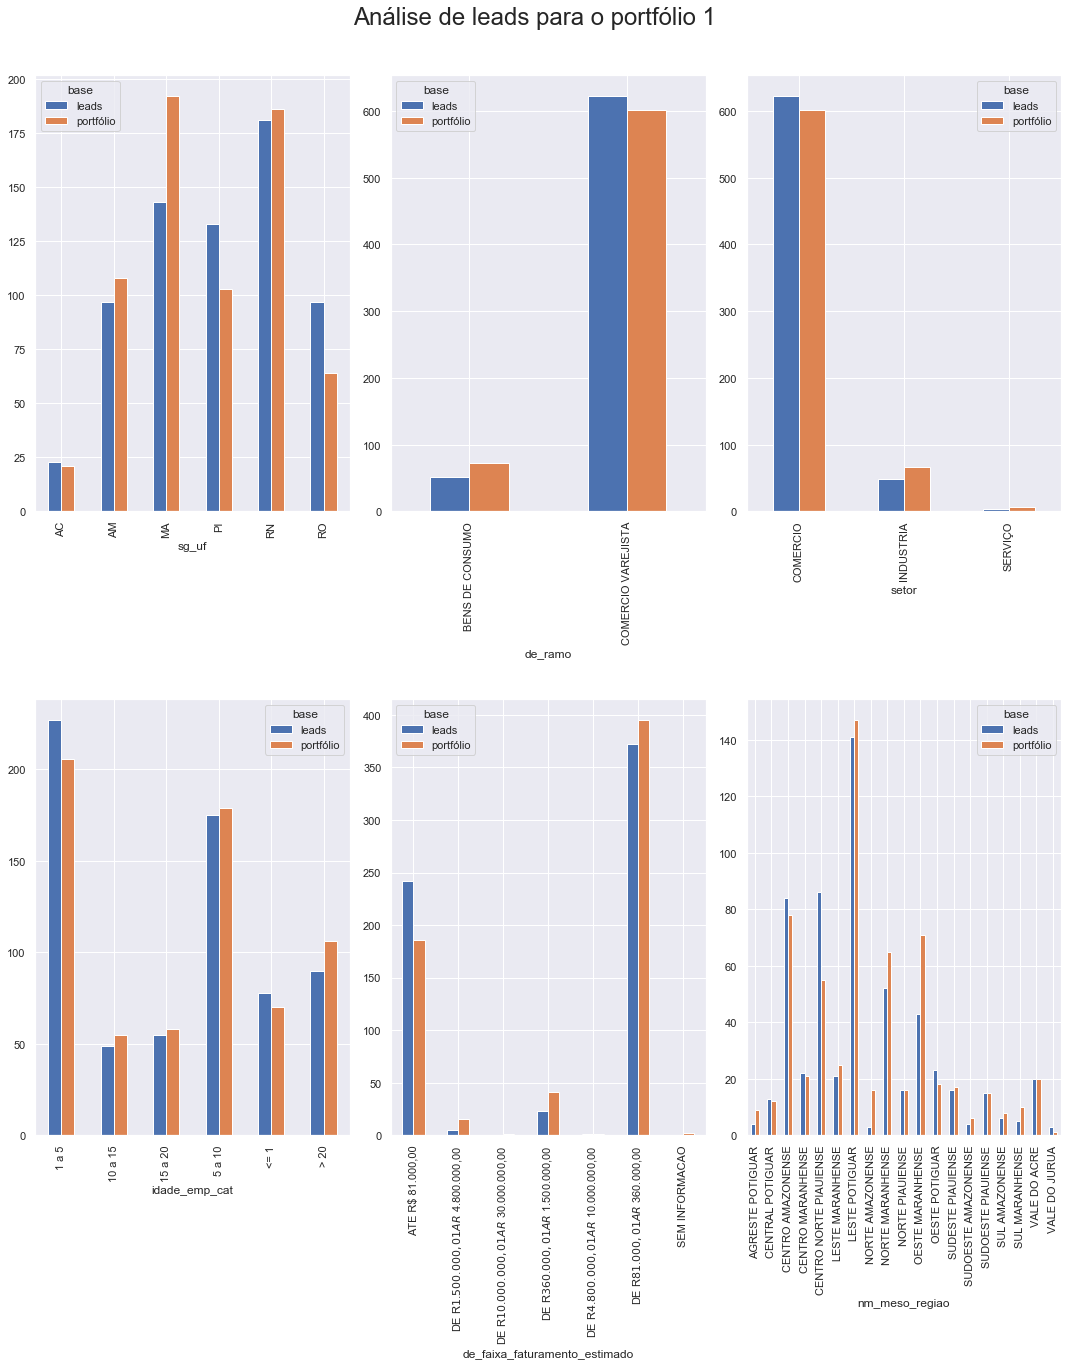

In [95]:
pf1 = pd.merge(pf1[['id']], market_original, on='id', how='inner')
leads = generate_leads(pf1, n_leads=pf1.shape[0])
leads_df = get_market_info(leads, market_original)
gen_comparative(pf1, leads_df, comparative_cols[1:], cols=3, title='Análise de leads para o portfólio 1')

Muito legal! Podemos observar que os leads estão muito próximos do que consta no portfólio. Inclusive na meso região, feature que nem usamos no nosso modelo. Parece que as features de latitude e longitude fizeram efeito aqui.

### Portfólio 2

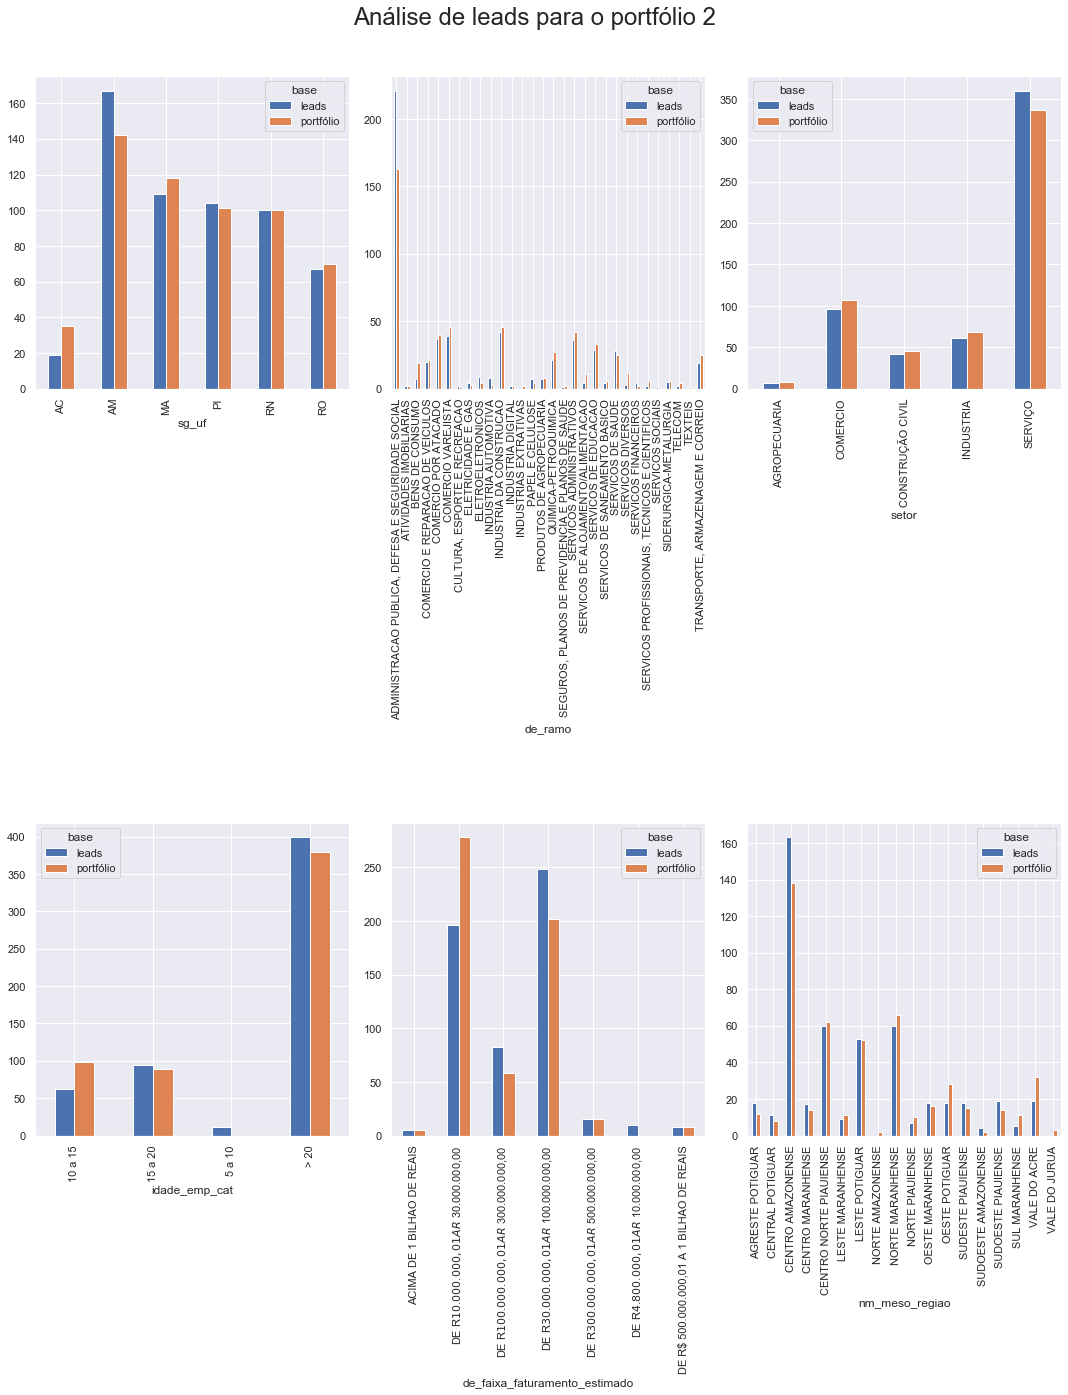

In [96]:
pf2 = pd.merge(pf2[['id']], market_original, on='id', how='inner')
leads = generate_leads(pf2, n_leads=pf2.shape[0])
leads_df = get_market_info(leads, market_original)
gen_comparative(pf2, leads_df, comparative_cols[1:], cols=3, title='Análise de leads para o portfólio 2')

O mesmo vemos para o portfólio 2, mesmo com ramo de atividade bem disperso.

### Portfólio 3

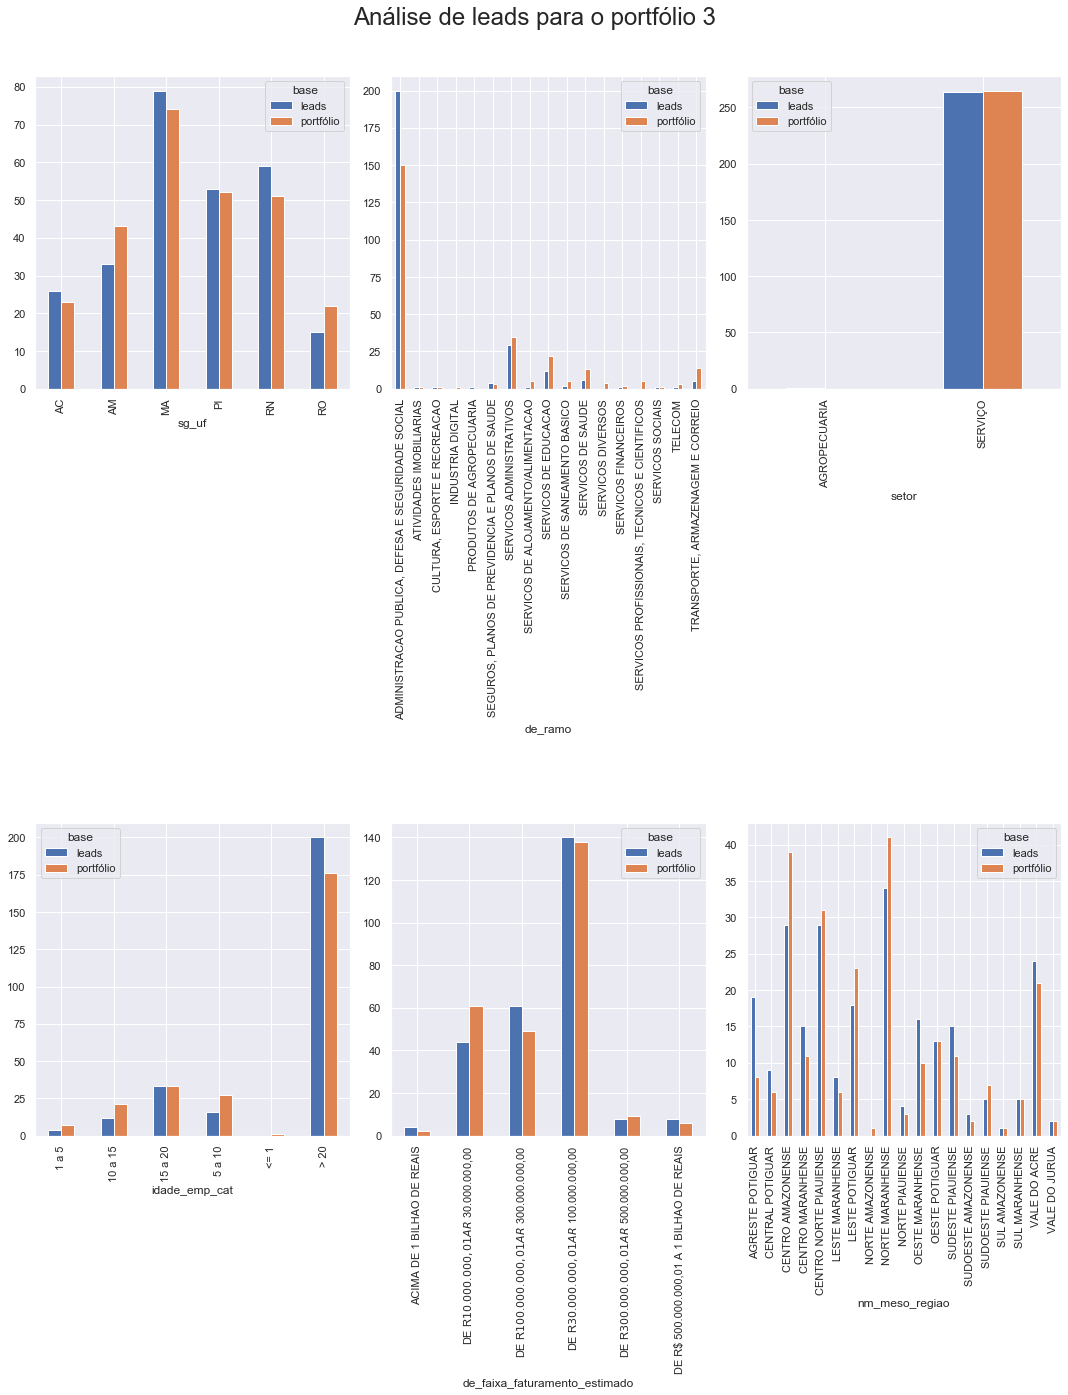

In [97]:
pf3 = pd.merge(pf3[['id']], market_original, on='id', how='inner')
leads = generate_leads(pf3, n_leads=pf3.shape[0])
leads_df = get_market_info(leads, market_original)
gen_comparative(pf3, leads_df, comparative_cols[1:], cols=3, title='Análise de leads para o portfólio 3')

Esse ficou legal também.

## Conclusões

Este desafio foi sensacional. Muitas features, muitos dados (e olha que é somente uma amostra), muitos desafios e para um tipo de problema que não tinha muito conhecimento, que é de `clustering`. Termino este curso fantástico oferecido pela Codenation muito satisfeito.